In [1]:
import pandas as pd
import numba
import numpy as np
import config
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

In [2]:
#Make a classification model for reorder

In [3]:
def apk(actual, predicted, k=3):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    
    actual = set(actual)
    predicted = list(predicted)
    
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in set(predicted[:i]):
            num_hits += 1.0
            score += num_hits / (i+1.0)
            
    if not actual:
        return 0.0

    return score / min(len(actual), k)


def mapk(actual, predicted, k=3):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    outs = [apk(a,p,k) for a,p in zip(actual, predicted)]
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)]), outs

In [4]:
def read_data(mode='val'):
    if mode =="val":
        train = pd.read_csv(config.tr_data, parse_dates=["OrderDate"])
        test = pd.read_csv(config.val_data)
    else:
        train = pd.read_csv(config.train_data)
        train["OrderDate"] = pd.to_datetime(train["OrderDate"], format="%d/%m/%y")
        test = pd.read_csv(config.test_data)
    products = pd.read_csv(config.product_data).pivot_table(index='productid',
                                                            columns='attribute_name',
                                                            values='attributevalue').fillna(-1).reset_index()
    train = pd.merge(train, products, on='productid', how='left').fillna(-1)
    return train, test

In [5]:
def get_df(train, test):
    train_tuples = []
    test_users = test.UserId.unique()
    for i, (uid, pid) in train[["UserId", "productid"]].drop_duplicates().iterrows():
        t = (int(uid), int(pid))
        if (int(uid) in test_users):
            train_tuples.append(t)
            
    df = pd.DataFrame(train_tuples, columns=['UserId', 'productid'])
    print(df.shape)
    return df

In [6]:
def get_features(history, df):
    # get time since previous
    #history["days_diff"] = history["OrderDate"].max() - history["OrderDate"]
    #df["prev_order"] = history.groupby("UserI")
    
    tmp = history.groupby(["UserId", "productid"]).size()
    tmp.name = 'usr_prd_cnt'
    df = df.join(tmp, on=["UserId", "productid"], how='left')
    df['usr_prd_cnt'] = np.loag1p(df['usr_prd_cnt'].fillna(0))

    # get time since previous
    tmp = history.groupby(["UserId", "productid"])["Quantity"].sum()
    tmp.name = 'usr_prd_qnty'
    df = df.join(tmp, on=["UserId", "productid"], how='left')
    df['usr_prd_qnty'] = df['usr_prd_qnty'].fillna(0)
    
    tmp = history.groupby(["UserId"])['Quantity'].sum()
    tmp.name = 'usr_qnty'
    df = df.join(tmp, on=["UserId"], how='left')
    df['usr_qnty'] = df['usr_qnty'].fillna(0)
    
    tmp = history.groupby(["UserId"])['Quantity'].mean()
    tmp.name = 'usr_mean'
    df = df.join(tmp, on=["UserId"], how='left')
    df['usr_mean'] = df['usr_mean'].fillna(0)

    tmp = history.groupby(["productid"])["Quantity"].sum()
    tmp.name = 'prd_qnty'
    df = df.join(tmp, on=["productid"], how='left')
    df['prd_qnty'] = df['prd_qnty'].fillna(0)
    
    tmp = history.groupby(["UserId"])["productid"].nunique()
    tmp.name = 'usr_unq_prd'
    df = df.join(tmp, on=["UserId"], how='left')
    df['usr_unq_prd'] = df['usr_unq_prd'].fillna(0)
    
    tmp = history.groupby(["productid"])["UserId"].nunique()
    tmp.name = 'prd_unq_usr'
    df = df.join(tmp, on=["productid"], how='left')
    df['prd_unq_usr'] = df['prd_unq_usr'].fillna(0)
    
    return df

In [7]:
def map_target(df, val):
    tmp = val[["UserId", "productid"]].drop_duplicates()
    tmp["target"]  = 1
    tmp = tmp.set_index(["UserId", "productid"])
    df = df.join(tmp, on=["UserId", "productid"])
    df["target"] = df["target"].fillna(0)
    return df

In [8]:
tr, val = read_data(mode='val')
val_df = get_df(tr, val)
val_df.head()

(11588, 2)


,UserId,productid
0,18075,12322648
1,6820,12371370
2,6820,12973004
3,6820,12657560
4,6820,11659914


In [9]:
val_df = get_features(tr, val_df)
val_df = map_target(val_df, val)
val_df.head()

,UserId,productid,usr_prd_cnt,usr_prd_qnty,usr_qnty,usr_mean,prd_qnty,usr_unq_prd,prd_unq_usr,target
0,18075,12322648,2,2,34,1.0,122,25,83,0.0
1,6820,12371370,1,1,11,1.0,50,11,37,0.0
2,6820,12973004,1,1,11,1.0,284,11,72,0.0
3,6820,12657560,1,1,11,1.0,59,11,41,0.0
4,6820,11659914,1,1,11,1.0,120,11,66,0.0


In [10]:
len(set(val_df.productid) - set(tr.productid))

0

In [11]:
cvlist = list(StratifiedKFold(5, shuffle=True, random_state=1234).split(val_df, val_df.target))

In [12]:
def get_val(X, cvlist, feats, lgb_params, X_test=None):
    val_preds = np.zeros((len(X),))
    test_preds = []
    for tr_idx, val_idx in cvlist:
        print("=========================")
        tr, val = X.iloc[tr_idx], X.iloc[val_idx]
        X_tr = tr[feats]
        X_val = val[feats]
        y_tr = tr["target"]
        y_val = val["target"]

        model = lgb.LGBMClassifier(**lgb_params)
        model.fit(X_tr, y_tr,
                  eval_set=[
                      (X_tr, y_tr),
                      (X_val, y_val)],
                  eval_metric='auc',
                  verbose=200, early_stopping_rounds=200,
                  )
        val_pred = model.predict_proba(X_val)[:, 1]
        val_preds[val_idx] = val_pred
        if X_test is not None:
            test_preds.append(model.predict_proba(X_test)[:, 1])
    test_preds = np.mean(test_preds, axis=0)
    return val_preds, test_preds

In [13]:
train, test = read_data(mode='test')
test_df = get_df(train, test)
test_df = get_features(train, test_df)
test_df.head()

(14645, 2)


,UserId,productid,usr_prd_cnt,usr_prd_qnty,usr_qnty,usr_mean,prd_qnty,usr_unq_prd,prd_unq_usr
0,18075,12322648,2,2,53,1.000000,124,41,83
1,26784,12658110,29,29,43476,1.015344,85,2689,40
2,26784,12407108,8,8,43476,1.015344,29,2689,17
3,26784,11660062,5,5,43476,1.015344,8,2689,4
4,26784,12407166,18,18,43476,1.015344,69,2689,43


In [28]:
feats = ['usr_prd_cnt', 'usr_unq_prd', 'prd_unq_usr', 'usr_prd_qnty', 'usr_qnty', 'usr_mean', 'prd_qnty']
params= {'n_estimators': 5000, 'learning_rate': 0.01, 'num_leaves': 8, 'seed': 1, 'subsample':0.8,
         'colsample_bytree':1.0, 'reg_lambda': 0.1}
val_preds, test_preds = get_val(val_df, cvlist, feats, params, X_test=test_df[feats])

Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.911696	valid_1's auc: 0.9133
[400]	training's auc: 0.922618	valid_1's auc: 0.914135
Early stopping, best iteration is:
[263]	training's auc: 0.916028	valid_1's auc: 0.915377
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.912436	valid_1's auc: 0.901293
[400]	training's auc: 0.924988	valid_1's auc: 0.904313
[600]	training's auc: 0.930794	valid_1's auc: 0.90506
[800]	training's auc: 0.934707	valid_1's auc: 0.904595
Early stopping, best iteration is:
[662]	training's auc: 0.932079	valid_1's auc: 0.905503
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.916374	valid_1's auc: 0.910857
Early stopping, best iteration is:
[117]	training's auc: 0.90772	valid_1's auc: 0.915145
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.917789	valid_1's auc: 0.886256
Early stopping, best iteration is:
[48]	tr

In [46]:
from sklearn.metrics import roc_auc_score, f1_score
print(roc_auc_score(val_df.target, val_preds))
f1_score(val_df.target, val_preds > 0.1)

0.4490954551015415


0.06795077581594434

In [30]:
np.mean(val_df.target), np.mean(val_preds)

(0.1156368657231619, 0.11567077653424725)

In [31]:
val_df['preds'] = val_preds
test_df['preds'] = test_preds

In [47]:
val_df = val_df.sort_values(by=['preds'], ascending=False)
test_df = test_df.sort_values(by=['preds'], ascending=False)

In [48]:
val_df.to_csv("outputs/val_df.csv", index=False)
test_df.to_csv("outputs/test_df.csv", index=False)

In [49]:
val_df.shape

(11588, 11)

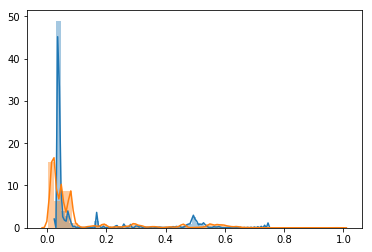

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(test_preds)
sns.distplot(val_preds)
plt.show()

In [51]:
sum(test_preds > 0.4)

1712

In [52]:
sum(val_df.groupby("UserId")["preds"].max() > 0.1)

36